In [1]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import yfinance as yf

In [86]:
#tickers = ['TSLA', 'SE', 'DOCU']
tickers = ['SE', 'DOCU']
all_tickers = " ".join(tickers)
# get the stock price of SE & TSLA & DOCU
ticker = yf.Tickers(all_tickers)

In [87]:
# get the historical data from 0810 to 1021
hist = ticker.history(start='2022-01-01', end='2022-11-05', group_by='ticker')

[*********************100%***********************]  2 of 2 completed


In [88]:
stock_df = pd.DataFrame(hist.stack(level=0).reset_index().rename(columns = {'level_1':'Ticker'}))
stock_df['Daily_Return'] = stock_df.sort_values(['Ticker', 'Date']).groupby('Ticker')['Close'].pct_change().dropna()

In [89]:
stock_df = stock_df[['Ticker','Date','Close','Daily_Return']]
stock_df.reset_index(drop=True)
stock_df.head()

Ticker       Date       Close  Daily_Return
0   DOCU 2022-01-03  157.009995           NaN
1     SE 2022-01-03  223.309998           NaN
2   DOCU 2022-01-04  154.440002     -0.016368
3     SE 2022-01-04  197.839996     -0.114057
4   DOCU 2022-01-05  144.169998     -0.066498

In [7]:
# get one day lag of daily return
stock_df['Daily_Return_Lag'] = stock_df.sort_values(['Ticker', 'Date']).groupby('Ticker')['Daily_Return'].shift(-1)
stock_df=stock_df.dropna()

In [652]:
# read from the pickle file
# This is the result of parse
articles_df = pd.read_pickle("yfinance_1106.p")  
articles_df = articles_df.rename(columns={'Date_published': 'Date'})

# normalize the date to match the format of historical data
articles_df['Date'] = pd.to_datetime(articles_df['Date']).dt.normalize()

In [653]:
# join daily return on the Date of published and Ticker
merged = pd.merge(articles_df,stock_df[['Ticker','Date','Daily_Return','Daily_Return_Lag']],how='left', on=['Ticker','Date'])
merged = merged.sort_values(by='Date', ascending=False).reset_index(drop=True)

In [84]:
# drop any na values
merged = merged.dropna()
merged = merged.reset_index(drop=True)
merged.head()

Title  \
0  DocuSign (DOCU) Dips More Than Broader Markets...   
1   Sea Limited to Report Third Quarter 2022 Results   
2  Sea Limited Sponsored ADR (SE) Gains As Market...   
3  A DocuSign, Inc. (NASDAQ:DOCU) insider increas...   
4  Another Cathie Wood Fund Exits Sea After $175 ...   

                                                Link                 Author  \
0  https://finance.yahoo.com/news/docusign-docu-d...  Zacks Equity Research   
1  https://finance.yahoo.com/news/sea-limited-rep...                          
2  https://finance.yahoo.com/news/sea-limited-spo...  Zacks Equity Research   
3  https://finance.yahoo.com/news/docusign-inc-na...         Simply Wall St   
4  https://finance.yahoo.com/news/another-cathie-...       Abhishek Vishnoi   

        Date                                           Contents Ticker  \
0 2022-11-03  DocuSign (DOCU) closed at $42.43 in the latest...   DOCU   
1 2022-11-01  SINGAPORE, November 01, 2022--(BUSINESS WIRE)-...     SE   
2 2022-10-31  Sea Limited Sponsored ADR (SE) closed at $49.6...     SE   
3 2022-10-31  Looking at DocuSign, Inc.'s (NASDAQ:DOCU ) ins...   DOCU   
4 2022-10-28  (Bloomberg) -- Funds managed by Cathie Wood ar...     SE   

   Title_Score  Average_Sentence_Score  Min_Sentence_Score  \
0          0.0                0.481481                -5.0   
1         -1.0                0.258065                -1.0   
2          1.0                0.414634                -3.0   
3          1.0                0.977273                -5.0   
4          0.0                0.866667                -3.0   

   Max_Sentence_Score  Average_Paragraph_Score  Min_Paragraph_Score  \
0                 7.0                 2.000000                -11.0   
1                 2.0                 0.333333                 -1.0   
2                 7.0                 1.545455                 -7.0   
3                 9.0                 3.583333                 -3.0   
4                 9.0                 0.650000                 -2.0   

   Max_Paragraph_Score  Article_Score  Daily_Return  Daily_Return_Lag  \
0                  7.0           26.0     -0.016914         -0.037002   
1                  7.0            8.0     -0.011473         -0.037467   
2                  6.0           17.0      0.002826         -0.011473   
3                 15.0           43.0     -0.008824         -0.008489   
4                  4.0           13.0     -0.001008          0.002826   

   Market_Move  Market_Move_Lag  
0            0                0  
1            0                0  
2            1                0  
3            0                0  
4            0                1

In [75]:
print(f'Total sample sizes: {merged.shape[0]}')

Total sample sizes: 119


## Conducting the Ljung-Box Test

- The null Hypothesis is that the residuals are independently distributed. 
- The alternative hypothesis is that the residuals are not independently distributed and exhibit a serial correlation.

In [5]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels

In [76]:
df2 = merged[['Date', 'Average_Sentence_Score']]
df2 = df2.set_index('Date')

acorr_ljungbox(df2, lags=[10], return_df=True)

lb_stat  lb_pvalue
10  14.668542   0.144622

In [82]:
df2 = merged[['Date', 'Average_Paragraph_Score']]
df2 = df2.set_index('Date')

acorr_ljungbox(df2, lags=[12], return_df=True)

lb_stat  lb_pvalue
12  19.944737   0.068139

In [83]:
df2 = merged[['Date', 'Article_Score']]
df2 = df2.set_index('Date')

acorr_ljungbox(df2, lags=[1], return_df=True)

lb_stat  lb_pvalue
1  1.605452   0.205132

**Conclusion:** All three p values I got from the above test are much higher than the general acceptable significance level of 0.05, so I would fail to reject the null hypothesis, meaning that there’s no autocorrelation between these explanatory variables.

## Conducting Engle/LM Test (ARCH Effect):  

Lagrange multiplier test to assess the significance of ARCH effects, 

- with the null hypothesis being there is no such effect. 
- If the squared residuals/errors of the time series model (stocks daily return are time-series) exhibit autocorrelation, then ARCH effects are present.

In [7]:
df2 = merged[['Date', 'Average_Sentence_Score']]
res = statsmodels.stats.diagnostic.het_arch(df2)
print(f'p-value for Lagrange multiplier test: {res[1]}')
print(f'p-value for F-test: {res[3]}')

p-value for Lagrange multiplier test: 0.9912490552795201
p-value for F-test: 0.9929990349484938


In [21]:
df2 = merged[['Date', 'Average_Paragraph_Score']]
res = statsmodels.stats.diagnostic.het_arch(df2)
print(f'p-value for Lagrange multiplier test: {res[1]}')
print(f'p-value for F-test: {res[3]}')

p-value for Lagrange multiplier test: 0.9815691559375287
p-value for F-test: 0.9849548674144086


In [23]:
df2 = merged[['Date', 'Article_Score']]
res = statsmodels.stats.diagnostic.het_arch(df2)
print(f'p-value for Lagrange multiplier test: {res[1]}')
print(f'p-value for F-test: {res[3]}')

p-value for Lagrange multiplier test: 0.6478415475160304
p-value for F-test: 0.6703628524250271


**Conclusion:** All three p-value for both tests are significantly larger than general acceptable significance level of 0.05, so I would fail to reject the null hypothesis, meaning that there is no such ARCH effect present.

Now after we make sure there's no autocorrelation between sentimental scores and dates (time-series hidden correlation), we could proceed the test.

## Visualization (Scatter plot of different combinations)

#### Average Sentence Score vs. Daily Return

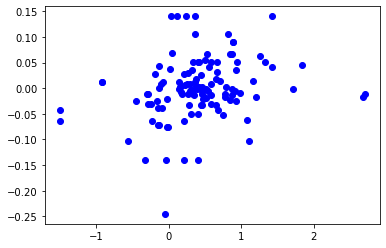

In [671]:
plt.scatter(merged['Average_Sentence_Score'], merged['Daily_Return'], c ="blue")

#### Average Sentence Score vs. Daily Return Lag (1 day)

Text(0, 0.5, 'Daily Return one day lag')

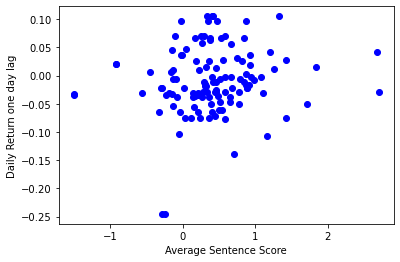

In [672]:
plt.scatter(merged['Average_Sentence_Score'], merged['Daily_Return_Lag'], c ="blue")
plt.xlabel('Average Sentence Score')
plt.ylabel('Daily Return one day lag')

#### Average Paragraph Score vs. Daily Return

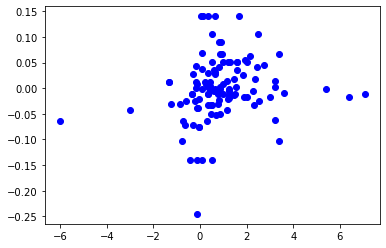

In [673]:
plt.scatter(merged['Average_Paragraph_Score'], merged['Daily_Return'], c ="blue")

#### Average Paragraph Score vs. Daily Return Lag (1 day)

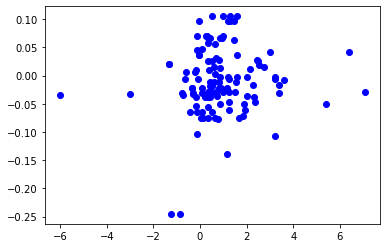

In [674]:
plt.scatter(merged['Average_Paragraph_Score'], merged['Daily_Return_Lag'], c ="blue")

#### Overall Article Score vs. Daily Return

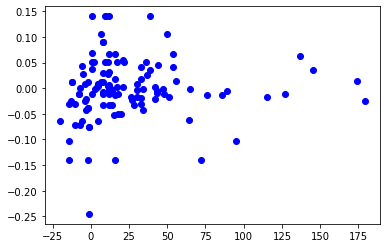

In [675]:
plt.scatter(merged['Article_Score'], merged['Daily_Return'], c ="blue")

#### Overall Article Score vs.  Daily Return Lag (1 day)

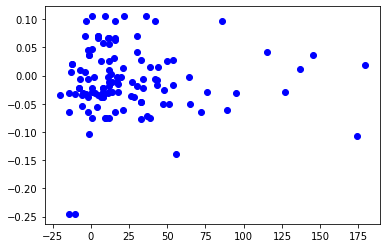

In [676]:
plt.scatter(merged['Article_Score'], merged['Daily_Return_Lag'], c ="blue")

#### Average Paragraph Score &  Average Sentence Score vs. Daily Return

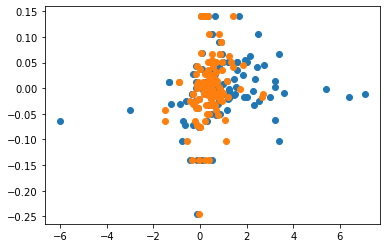

In [677]:
plt.scatter(merged['Average_Paragraph_Score'], merged['Daily_Return'])
plt.scatter(merged['Average_Sentence_Score'], merged['Daily_Return'])
plt.show()

#### Average Paragraph Score &  Average Sentence Score vs. Daily Return Lag (1 day)

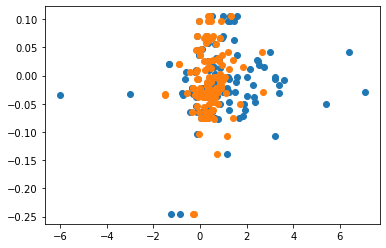

In [678]:
plt.scatter(merged['Average_Paragraph_Score'], merged['Daily_Return_Lag'])
plt.scatter(merged['Average_Sentence_Score'], merged['Daily_Return_Lag'])
plt.show()

## Linear Regression

In [9]:
# statsmodels package
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [10]:
# sklearn package
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, f1_score, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, f1_score,classification_report
from sklearn.model_selection import train_test_split

### 1. Daily return with no lag vs. Average Sentence Score

Using the statsmodel first

In [681]:
no_Lag = smf.ols('Daily_Return ~ Average_Sentence_Score', data=merged).fit()
no_Lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Daily_Return   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     7.334
Date:                Sun, 06 Nov 2022   Prob (F-statistic):            0.00778
Time:                        10:25:47   Log-Likelihood:                 170.22
No. Observations:                 119   AIC:                            -336.4
Df Residuals:                     117   BIC:                            -330.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0100      0.006     -1.567      0.120      -0.023       0.003
Average_Sentence_Score     0.0237      0.009      2.708      0.008       0.006       0.041
==============================================================================
Omnibus:                       12.540   Durbin-Watson:                   0.811
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.391
Skew:                          -0.318   Prob(JB):                     6.84e-07
Kurtosis:                       5.307   Cond. No.                         2.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now use the sklearn, we firstly apply the StandardScaler to make sure the features are on the same scale.

In [682]:
num_cols_1 = ['Average_Sentence_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Daily_Return']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [683]:
# linear regression
clf = LinearRegression()
clf.fit(X_train_xformed,y_train.values)

LinearRegression()

In [684]:
# Predict!

print('Train Scores\n')
train_pred = clf.predict(X_train_xformed)

print(f'R2: {r2_score(y_train.values, train_pred)}')

print('\nTest Scores\n')
test_pred = clf.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values, test_pred)}')

Intercept=clf.intercept_
Coefficients=clf.coef_
print(f'Intercept: {round(Intercept[0],6)}, and Coefficients: {round(Coefficients[0][0],6)}')

residuals = y_test-test_pred

Train Scores

R2: 0.06881679329314916

Test Scores

R2: 0.029618941948703514
Intercept: 0.001799, and Coefficients: 0.014853


#### Visualize the linear relationship

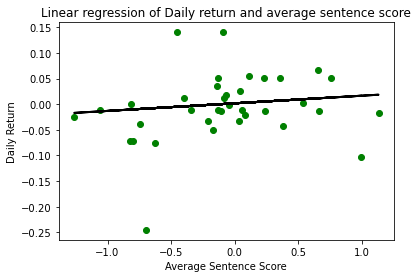

In [685]:
plt.scatter(X_test_xformed, y_test,color='g')
plt.xlabel('Average Sentence Score')
plt.ylabel('Daily Return')
plt.title('Linear regression of Daily return and average sentence score')
plt.plot(X_test_xformed, clf.predict(X_test_xformed),color='k',linewidth=2) 
plt.show()

eval_env: 1


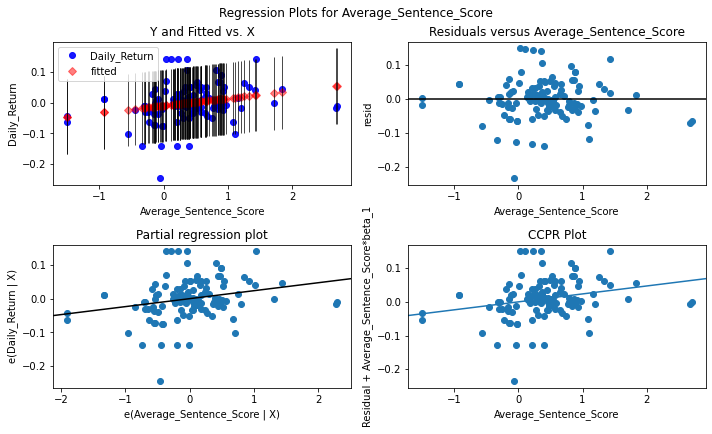

In [686]:
fig = plt.figure(figsize=(10, 6))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(no_Lag,
                                    'Average_Sentence_Score',
                                    fig=fig)

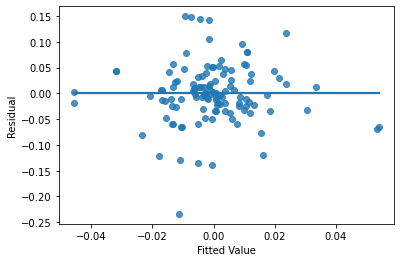

In [687]:
import seaborn as sns
sns.regplot(x=no_Lag.fittedvalues, y=no_Lag.resid, ci=None)
plt.ylabel('Residual')
plt.xlabel('Fitted Value')
plt.show()

### 2. Daily return with one day lag vs. Average Sentence Score

In [689]:
one_Lag = smf.ols('Daily_Return_Lag ~ Average_Sentence_Score', data=merged).fit()
one_Lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Daily_Return_Lag   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.082
Date:                Sun, 06 Nov 2022   Prob (F-statistic):              0.152
Time:                        10:26:02   Log-Likelihood:                 169.20
No. Observations:                 119   AIC:                            -334.4
Df Residuals:                     117   BIC:                            -328.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0144      0.006     -2.220      0.028      -0.027      -0.002
Average_Sentence_Score     0.0127      0.009      1.443      0.152      -0.005       0.030
==============================================================================
Omnibus:                       19.474   Durbin-Watson:                   0.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.544
Skew:                          -0.647   Prob(JB):                     1.57e-09
Kurtosis:                       5.550   Cond. No.                         2.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

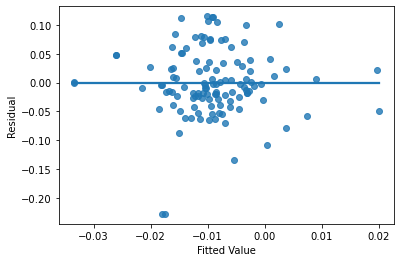

In [690]:
import seaborn as sns
sns.regplot(x=one_Lag.fittedvalues, y=one_Lag.resid, ci=None)
plt.ylabel('Residual')
plt.xlabel('Fitted Value')
plt.show()

In [691]:
statsmodels.stats.diagnostic.het_arch(one_Lag.resid)

(38.4911662758177,
 3.116061109758779e-05,
 5.349874754397493,
 2.8453961017315e-06)

In [692]:
# see the correlation between the two variables, 0.1259 is very weak
df_1 = merged[['Average_Sentence_Score', 'Daily_Return_Lag']]
df_1.corr()

Average_Sentence_Score  Daily_Return_Lag
Average_Sentence_Score                1.000000          0.132236
Daily_Return_Lag                      0.132236          1.000000

In [693]:
num_cols_1 = ['Average_Sentence_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Daily_Return_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [694]:
# linear regression
clf = LinearRegression()
clf.fit(X_train_xformed,y_train.values)

LinearRegression()

In [695]:
# Predict!

print('Train Scores\n')
train_pred = clf.predict(X_train_xformed)

print(f'R2: {r2_score(y_train.values, train_pred)}')

print('\nTest Scores\n')
test_pred = clf.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values, test_pred)}')

Intercept=clf.intercept_
Coefficients=clf.coef_
print(f'Intercept: {round(Intercept[0],6)}, and Coefficients: {round(Coefficients[0][0],6)}')

Train Scores

R2: 0.0009870123883800597

Test Scores

R2: 0.011178966788284894
Intercept: -0.01067, and Coefficients: 0.001775


#### Visualize the linear relationship

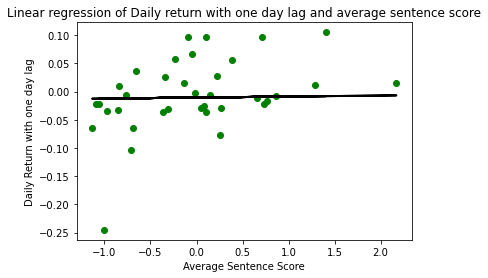

In [696]:
plt.scatter(X_test_xformed, y_test,color='g')
plt.xlabel('Average Sentence Score')
plt.ylabel('Daily Return with one day lag')
plt.title('Linear regression of Daily return with one day lag and average sentence score')
plt.plot(X_test_xformed, clf.predict(X_test_xformed),color='k',linewidth=2) 
plt.show()

eval_env: 1


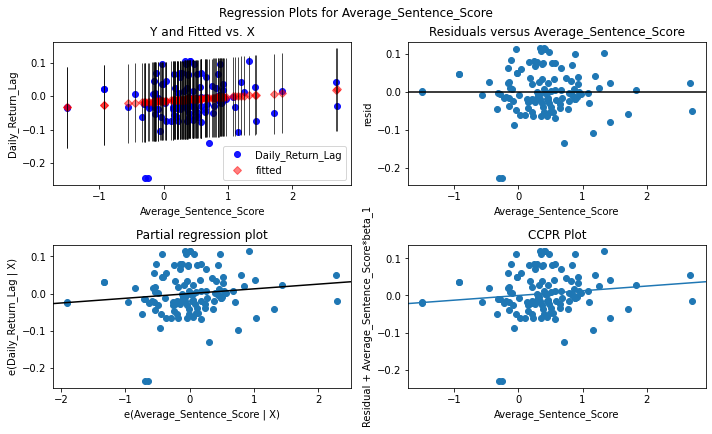

In [697]:
fig = plt.figure(figsize=(10, 6))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(one_Lag,
                                    'Average_Sentence_Score',
                                    fig=fig)

### 3. Daily return vs. Average Paragraph Score

In [698]:
no_Lag = smf.ols('Daily_Return ~ Average_Paragraph_Score', data=merged).fit()
no_Lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Daily_Return   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.684
Date:                Sun, 06 Nov 2022   Prob (F-statistic):             0.0574
Time:                        10:26:14   Log-Likelihood:                 168.45
No. Observations:                 119   AIC:                            -332.9
Df Residuals:                     117   BIC:                            -327.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0063      0.006     -1.019      0.310      -0.019       0.006
Average_Paragraph_Score     0.0068      0.004      1.919      0.057      -0.000       0.014
==============================================================================
Omnibus:                       12.462   Durbin-Watson:                   0.793
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.554
Skew:                          -0.307   Prob(JB):                     6.30e-07
Kurtosis:                       5.320   Cond. No.                         2.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [700]:
# see the correlation between the two variables, 0.1248 is very weak
df_1 = merged[['Average_Paragraph_Score', 'Daily_Return']]
df_1.corr()

Average_Paragraph_Score  Daily_Return
Average_Paragraph_Score                 1.000000      0.174718
Daily_Return                            0.174718      1.000000

In [701]:
num_cols_1 = ['Average_Paragraph_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Daily_Return']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [702]:
# linear regression
clf = LinearRegression()
clf.fit(X_train_xformed,y_train.values)

LinearRegression()

In [703]:
# Predict!

print('Train Scores\n')
train_pred = clf.predict(X_train_xformed)

print(f'R2: {r2_score(y_train.values, train_pred)}')

print('\nTest Scores\n')
test_pred = clf.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values, test_pred)}')

Intercept=clf.intercept_
Coefficients=clf.coef_
print(f'Intercept: {round(Intercept[0],6)}, and Coefficients: {round(Coefficients[0][0],6)}')

Train Scores

R2: 0.011286959455628298

Test Scores

R2: 0.06454891345484348
Intercept: 0.000957, and Coefficients: 0.006563


#### Visualize the linear relationship

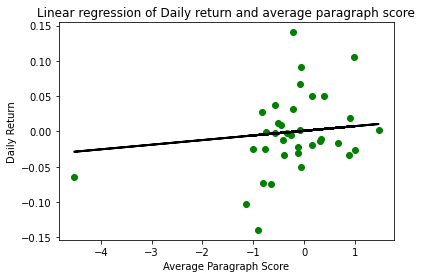

In [704]:
plt.scatter(X_test_xformed, y_test,color='g')
plt.xlabel('Average Paragraph Score')
plt.ylabel('Daily Return')
plt.title('Linear regression of Daily return and average paragraph score')
plt.plot(X_test_xformed, clf.predict(X_test_xformed),color='k',linewidth=2) 
plt.show()

eval_env: 1


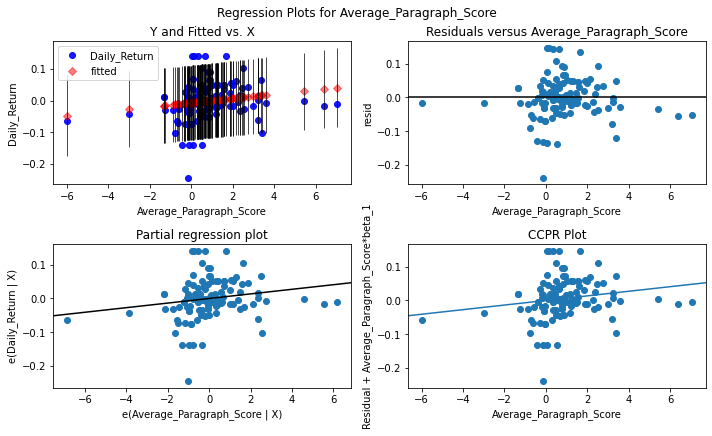

In [705]:
fig = plt.figure(figsize=(10, 6))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(no_Lag,
                                    'Average_Paragraph_Score',
                                    fig=fig)

### 4. Daily return with one day lag vs. Average Paragraph Score

In [706]:
one_Lag = smf.ols('Daily_Return_Lag ~ Average_Paragraph_Score', data=merged).fit()
one_Lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Daily_Return_Lag   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.240
Date:                Sun, 06 Nov 2022   Prob (F-statistic):              0.268
Time:                        10:26:20   Log-Likelihood:                 168.77
No. Observations:                 119   AIC:                            -333.5
Df Residuals:                     117   BIC:                            -328.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0126      0.006     -2.029      0.045      -0.025      -0.000
Average_Paragraph_Score     0.0039      0.004      1.114      0.268      -0.003       0.011
==============================================================================
Omnibus:                       19.215   Durbin-Watson:                   0.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.051
Skew:                          -0.637   Prob(JB):                     2.01e-09
Kurtosis:                       5.541   Cond. No.                         2.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [708]:
# see the correlation between the two variables, 0.070647 is very weak
df_1 = merged[['Average_Paragraph_Score', 'Daily_Return_Lag']]
df_1.corr()

Average_Paragraph_Score  Daily_Return_Lag
Average_Paragraph_Score                 1.000000          0.102422
Daily_Return_Lag                        0.102422          1.000000

In [709]:
num_cols_1 = ['Average_Paragraph_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Daily_Return_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [710]:
# linear regression
clf = LinearRegression()
clf.fit(X_train_xformed,y_train.values)

LinearRegression()

In [711]:
# Predict!

print('Train Scores\n')
train_pred = clf.predict(X_train_xformed)

print(f'R2: {r2_score(y_train.values, train_pred)}')

print('\nTest Scores\n')
test_pred = clf.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values, test_pred)}')

Intercept=clf.intercept_
Coefficients=clf.coef_
print(f'Intercept: {round(Intercept[0],6)}, and Coefficients: {round(Coefficients[0][0],6)}')

Train Scores

R2: 0.0013556254529178968

Test Scores

R2: 0.003626500646830233
Intercept: -0.007585, and Coefficients: 0.001689


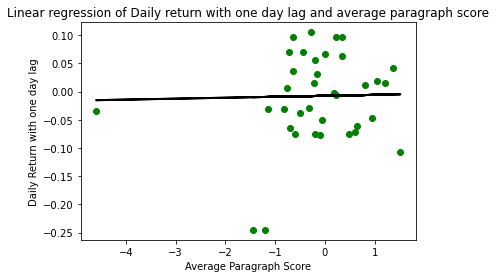

In [712]:
plt.scatter(X_test_xformed, y_test,color='g')
plt.xlabel('Average Paragraph Score')
plt.ylabel('Daily Return with one day lag')
plt.title('Linear regression of Daily return with one day lag and average paragraph score')
plt.plot(X_test_xformed, clf.predict(X_test_xformed),color='k',linewidth=2) 
plt.show()

eval_env: 1


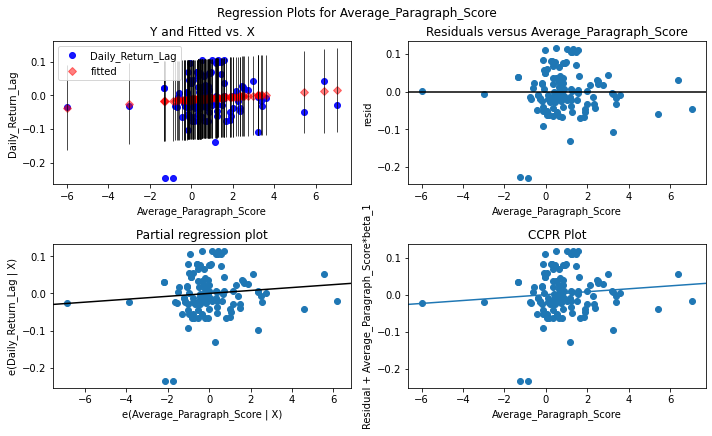

In [713]:
fig = plt.figure(figsize=(10, 6))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(one_Lag,
                                    'Average_Paragraph_Score',
                                    fig=fig)

### 5. Daily return vs. Article_Score

In [714]:
no_Lag = smf.ols('Daily_Return ~ Article_Score', data=merged).fit()
no_Lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Daily_Return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.4353
Date:                Sun, 06 Nov 2022   Prob (F-statistic):              0.511
Time:                        10:26:25   Log-Likelihood:                 166.82
No. Observations:                 119   AIC:                            -329.6
Df Residuals:                     117   BIC:                            -324.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0029      0.007     -0.435      0.665      -0.016       0.010
Article_Score  9.893e-05      0.000      0.660      0.511      -0.000       0.000
==============================================================================
Omnibus:                       13.124   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.141
Skew:                          -0.357   Prob(JB):                     4.70e-07
Kurtosis:                       5.317   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [716]:
num_cols_1 = ['Article_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Daily_Return']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [717]:
# linear regression
clf = LinearRegression()
clf.fit(X_train_xformed,y_train.values)

LinearRegression()

In [718]:
# Predict!

print('Train Scores\n')
train_pred = clf.predict(X_train_xformed)

print(f'R2: {r2_score(y_train.values, train_pred)}')

print('\nTest Scores\n')
test_pred = clf.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values, test_pred)}')

Intercept=clf.intercept_
Coefficients=clf.coef_
print(f'Intercept: {round(Intercept[0],6)}, and Coefficients: {round(Coefficients[0][0],6)}')

Train Scores

R2: 3.12096325222333e-05

Test Scores

R2: -0.00429103142482834
Intercept: -0.000521, and Coefficients: -0.000362


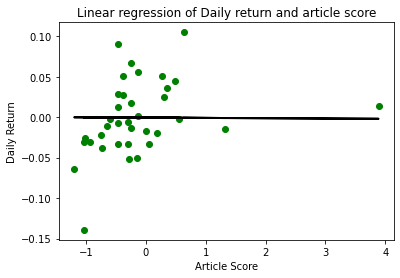

In [719]:
plt.scatter(X_test_xformed, y_test,color='g')
plt.xlabel('Article Score')
plt.ylabel('Daily Return')
plt.title('Linear regression of Daily return and article score')
plt.plot(X_test_xformed, clf.predict(X_test_xformed),color='k',linewidth=2) 
plt.show()

eval_env: 1


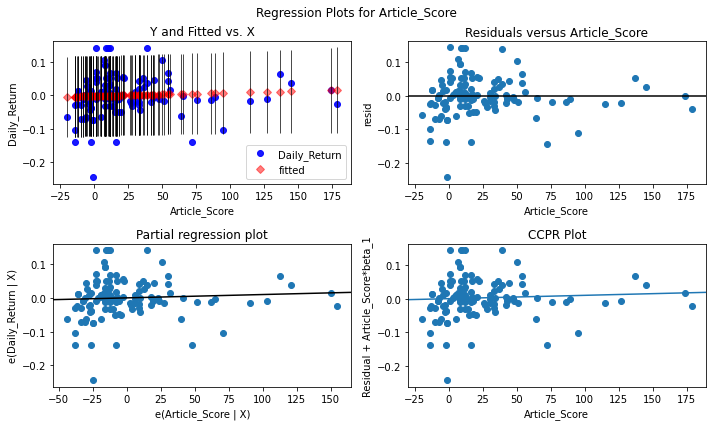

In [720]:
fig = plt.figure(figsize=(10, 6))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(no_Lag,
                                    'Article_Score',
                                    fig=fig)

### 6. Daily return with one day lag vs. Article Score

In [721]:
one_Lag = smf.ols('Daily_Return_Lag ~ Article_Score', data=merged).fit()
one_Lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Daily_Return_Lag   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.02815
Date:                Sun, 06 Nov 2022   Prob (F-statistic):              0.867
Time:                        10:26:31   Log-Likelihood:                 168.16
No. Observations:                 119   AIC:                            -332.3
Df Residuals:                     117   BIC:                            -326.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0098      0.007     -1.508      0.134      -0.023       0.003
Article_Score  2.488e-05      0.000      0.168      0.867      -0.000       0.000
==============================================================================
Omnibus:                       22.186   Durbin-Watson:                   0.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.993
Skew:                          -0.704   Prob(JB):                     8.45e-12
Kurtosis:                       5.881   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [723]:
num_cols_1 = ['Article_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Daily_Return_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [724]:
# linear regression
clf = LinearRegression()
clf.fit(X_train_xformed,y_train.values)

LinearRegression()

In [725]:
# Predict!

print('Train Scores\n')
train_pred = clf.predict(X_train_xformed)

print(f'R2: {r2_score(y_train.values, train_pred)}')

print('\nTest Scores\n')
test_pred = clf.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values, test_pred)}')

Intercept=clf.intercept_
Coefficients=clf.coef_
print(f'Intercept: {round(Intercept[0],6)}, and Coefficients: {round(Coefficients[0][0],6)}')

Train Scores

R2: 0.0001772019661850921

Test Scores

R2: -0.003757347822427981
Intercept: -0.009134, and Coefficients: -0.000836


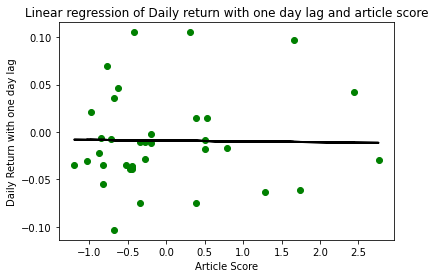

In [726]:
plt.scatter(X_test_xformed, y_test,color='g')
plt.xlabel('Article Score')
plt.ylabel('Daily Return with one day lag')
plt.title('Linear regression of Daily return with one day lag and article score')
plt.plot(X_test_xformed, clf.predict(X_test_xformed),color='k',linewidth=2) 
plt.show()

eval_env: 1


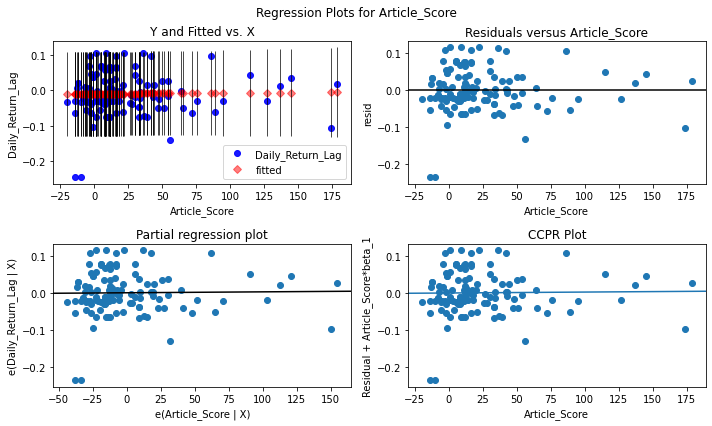

In [727]:
fig = plt.figure(figsize=(10, 6))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(one_Lag,
                                    'Article_Score',
                                    fig=fig)

### finally, let's see what happens if we try to fit multiple features

In [728]:
one_Lag = smf.ols('Daily_Return_Lag ~ Average_Sentence_Score+Average_Paragraph_Score+Article_Score', data=merged).fit()
one_Lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Daily_Return_Lag   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.083
Date:                Sun, 06 Nov 2022   Prob (F-statistic):              0.359
Time:                        10:26:38   Log-Likelihood:                 169.80
No. Observations:                 119   AIC:                            -331.6
Df Residuals:                     115   BIC:                            -320.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0129      0.007     -1.922      0.057      -0.026       0.000
Average_Sentence_Score      0.0260      0.022      1.200      0.233      -0.017       0.069
Average_Paragraph_Score    -0.0024      0.009     -0.280      0.780      -0.020       0.015
Article_Score              -0.0002      0.000     -0.981      0.329      -0.001       0.000
==============================================================================
Omnibus:                       21.217   Durbin-Watson:                   0.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.830
Skew:                          -0.687   Prob(JB):                     6.78e-11
Kurtosis:                       5.749   Cond. No.                         186.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [731]:
# check multicollinearity
df_1 = merged[['Average_Sentence_Score', 'Average_Paragraph_Score', 'Article_Score']]
df_1.corr()

Average_Sentence_Score  Average_Paragraph_Score  \
Average_Sentence_Score                 1.000000                 0.909345   
Average_Paragraph_Score                0.909345                 1.000000   
Article_Score                          0.663387                 0.659684   

                         Article_Score  
Average_Sentence_Score        0.663387  
Average_Paragraph_Score       0.659684  
Article_Score                 1.000000

Possible Multicollinearity Condition here because we see high correlaiton of 0.91 between Average_Paragraph_Score and Average_Sentence_Score, and 0.66 between Article_Score and Average Sentence Score

In [845]:
# Let's now fit daily return (no lag) with Average_Sentence_Score+Article_Score
no_Lag = smf.ols('Daily_Return ~ Average_Sentence_Score+Article_Score', data=merged).fit()
no_Lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Daily_Return   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     4.834
Date:                Mon, 07 Nov 2022   Prob (F-statistic):            0.00963
Time:                        10:36:36   Log-Likelihood:                 171.37
No. Observations:                 119   AIC:                            -336.7
Df Residuals:                     116   BIC:                            -328.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0077      0.007     -1.178      0.241      -0.021       0.005
Average_Sentence_Score     0.0352      0.012      3.034      0.003       0.012       0.058
Article_Score             -0.0003      0.000     -1.502      0.136      -0.001    9.28e-05
==============================================================================
Omnibus:                       13.501   Durbin-Watson:                   0.901
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.368
Skew:                          -0.352   Prob(JB):                     1.54e-07
Kurtosis:                       5.415   Cond. No.                         97.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [846]:
num_cols_1 = ['Average_Sentence_Score', 'Article_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Daily_Return_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [847]:
# linear regression
clf = LinearRegression()
clf.fit(X_train_xformed,y_train.values)

LinearRegression()

In [848]:
# Predict!

print('Train Scores\n')
train_pred = clf.predict(X_train_xformed)

print(f'R2: {r2_score(y_train.values, train_pred)}')

print('\nTest Scores\n')
test_pred = clf.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values, test_pred)}')

Intercept=clf.intercept_
Coefficients=clf.coef_
print(f'Intercept: {round(Intercept[0],6)}, and Coefficients: {round(Coefficients[0][0],6)}')

Train Scores

R2: 0.03024393246964452

Test Scores

R2: 0.0036139357231796954
Intercept: -0.007895, and Coefficients: 0.013378


In [849]:
num_cols_1 = ['Average_Sentence_Score', 'Article_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Daily_Return']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

# linear regression
clf = LinearRegression()
clf.fit(X_train_xformed,y_train.values)

LinearRegression()

In [850]:
# Predict!

print('Train Scores\n')
train_pred = clf.predict(X_train_xformed)

print(f'R2: {r2_score(y_train.values, train_pred)}')

print('\nTest Scores\n')
test_pred = clf.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values, test_pred)}')

Intercept=clf.intercept_
Coefficients=clf.coef_
print(f'Intercept: {round(Intercept[0],6)}, and Coefficients: {round(Coefficients[0][0],6)}')

Train Scores

R2: 0.10203628759681493

Test Scores

R2: 0.03296637359529153
Intercept: 0.000833, and Coefficients: 0.022197


### Conclusion: Why linear regression is not a good fit?
- By looking at the **residual plot** for each combination
1. If there's a linear relationship, we would expect the residuals of all the sample data fitted to the model to be equally distributed above and below 0 as we move from left to right
2. We would expect constant variance of residual from left to right

However, from each residual plot above, these two conditions certainly don't meet

- We could also see the **correlation**: as I calculated them out, most of them have a correlation below 0.13, so very weak linear relationship between the two variables

## Logistic Regression

In [11]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

firstly we need to re-classify the daily return in cateogorical data

In [12]:
# if daily return is positive, there is a market upward move
merged['Market_Move'] = np.where(merged['Daily_Return'] > 0, 1, 0)

In [13]:
# lag
merged['Market_Move_Lag'] = np.where(merged['Daily_Return_Lag'] > 0, 1, 0)

### 1. Daily market move with no lag vs. Average Sentence Score

<AxesSubplot:xlabel='Average_Sentence_Score', ylabel='Market_Move'>

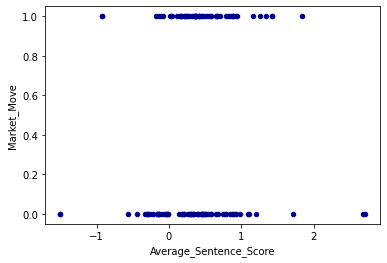

In [738]:
merged.plot.scatter(x='Average_Sentence_Score',
                      y='Market_Move',
                      c='DarkBlue')

As we can see from the graph, it seems that Logistic Regression is not a good fit model for these.
But let's still try to fit the logistic regression.

In [739]:
num_cols_1 = ['Average_Sentence_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)])

y_col = ['Market_Move']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [740]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_xformed,y_train.values.ravel())

In [741]:
# Predict!
print('Train Scores\n')
train_pred = LR.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = LR.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Jaccard score: {jaccard_score(y_test.values.ravel(), test_pred,pos_label=0)}') # bad jaccard score
print(f'Log loss score: {log_loss(y_test.values.ravel(), test_pred)}')

Train Scores

Precision Score: 0.42
Recall Score: 0.54
F1 Score: 0.42

Test Scores

Precision Score: 0.76
Recall Score: 0.56
F1 Score: 0.45
Jaccard score: 0.5294117647058824
Log loss score: 15.350567286626971


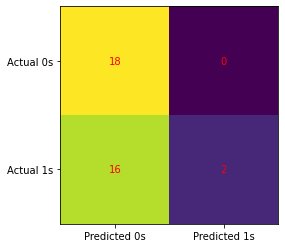

In [742]:
cm = confusion_matrix(y_test.values.ravel(), test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### 2. Daily market move with one day lag vs. Average Sentence Score

<AxesSubplot:xlabel='Average_Sentence_Score', ylabel='Market_Move_Lag'>

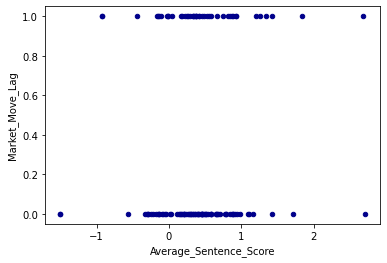

In [743]:
merged.plot.scatter(x='Average_Sentence_Score',
                      y='Market_Move_Lag',
                      c='DarkBlue')

In [744]:
num_cols_1 = ['Average_Sentence_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)])

y_col = ['Market_Move_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [745]:
LR = LogisticRegression(C=0.01, solver='sag').fit(X_train_xformed,y_train.values.ravel())

In [746]:
# Predict!
print('Train Scores\n')
train_pred = LR.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = LR.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Jaccard score: {jaccard_score(y_test.values.ravel(), test_pred,pos_label=0)}') # bad jaccard score
print(f'Log loss score: {log_loss(y_test.values.ravel(), test_pred)}')

Train Scores

Precision Score: 0.64
Recall Score: 1.00
F1 Score: 0.78

Test Scores

Precision Score: 0.61
Recall Score: 1.00
F1 Score: 0.76
Jaccard score: 0.6111111111111112
Log loss score: 13.431746375798598


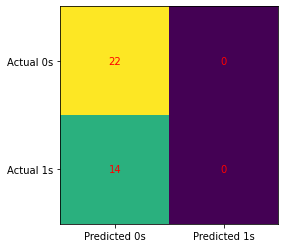

In [747]:
cm = confusion_matrix(y_test.values.ravel(), test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [748]:
# calculate the theta, boundary line
print(LR.intercept_[0])
print(LR.coef_[0][0])

-0.56908945279862
0.005974586365784856


### 3. Daily market move vs. Average Paragraph Score

<AxesSubplot:xlabel='Average_Paragraph_Score', ylabel='Market_Move'>

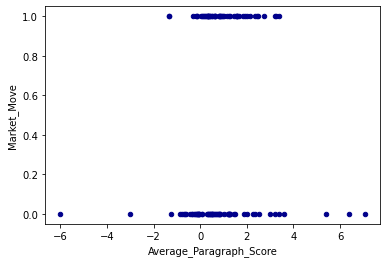

In [749]:
merged.plot.scatter(x='Average_Paragraph_Score',
                      y='Market_Move',
                      c='DarkBlue')

In [750]:
num_cols_1 = ['Average_Paragraph_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)])

y_col = ['Market_Move']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [751]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_xformed,y_train.values.ravel())

In [752]:
# Predict!
print('Train Scores\n')
train_pred = LR.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = LR.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Jaccard score: {jaccard_score(y_test.values.ravel(), test_pred,pos_label=0)}') # bad jaccard score
print(f'Log loss score: {log_loss(y_test.values.ravel(), test_pred)}')

Train Scores

Precision Score: 0.55
Recall Score: 1.00
F1 Score: 0.71

Test Scores

Precision Score: 0.53
Recall Score: 1.00
F1 Score: 0.69
Jaccard score: 0.5277777777777778
Log loss score: 16.309977742041156


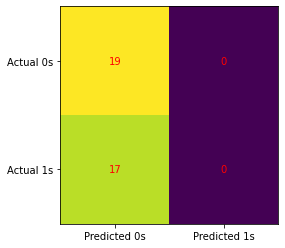

In [753]:
cm = confusion_matrix(y_test.values.ravel(), test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [754]:
print(LR.intercept_[0])
print(LR.coef_.T[0][0])

-0.0372670807453416
-0.0040728501424613876


### 4. Daily market move with one day lag vs. Average Paragraph Score

<AxesSubplot:xlabel='Average_Paragraph_Score', ylabel='Market_Move_Lag'>

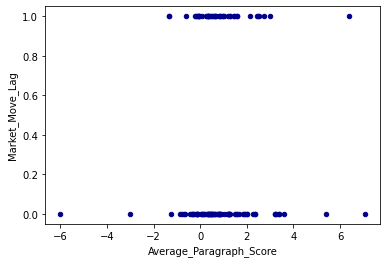

In [755]:
merged.plot.scatter(x='Average_Paragraph_Score',
                      y='Market_Move_Lag',
                      c='DarkBlue')

In [756]:
num_cols_1 = ['Average_Paragraph_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)])

y_col = ['Market_Move_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [757]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_xformed,y_train.values.ravel())

In [758]:
# Predict!
print('Train Scores\n')
train_pred = LR.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = LR.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Jaccard score: {jaccard_score(y_test.values.ravel(), test_pred,pos_label=0)}') # bad jaccard score
print(f'Log loss score: {log_loss(y_test.values.ravel(), test_pred)}')

Train Scores

Precision Score: 0.65
Recall Score: 1.00
F1 Score: 0.79

Test Scores

Precision Score: 0.58
Recall Score: 1.00
F1 Score: 0.74
Jaccard score: 0.5833333333333334
Log loss score: 14.391156831212783


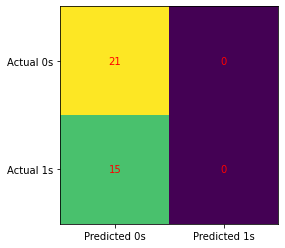

In [759]:
cm = confusion_matrix(y_test.values.ravel(), test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [760]:
# calculate the theta, boundary line
print(LR.intercept_[0])
print(LR.coef_.T[0][0])

-0.10353661075699051
0.01563465152753572


### 5. Daily market move with one day lag vs. Article Score

<AxesSubplot:xlabel='Article_Score', ylabel='Market_Move_Lag'>

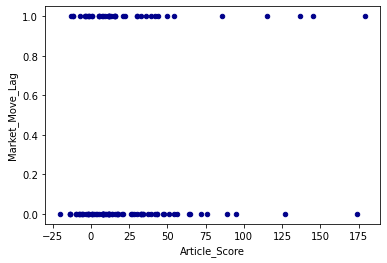

In [761]:
merged.plot.scatter(x='Article_Score',
                      y='Market_Move_Lag',
                      c='DarkBlue')

In [762]:
num_cols_1 = ['Article_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)])

y_col = ['Market_Move_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [763]:
LR = LogisticRegression().fit(X_train_xformed,y_train.values.ravel())

In [764]:
# Predict!
print('Train Scores\n')
train_pred = LR.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = LR.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Jaccard score: {jaccard_score(y_test.values.ravel(), test_pred,pos_label=0)}') # bad jaccard score
print(f'Log loss score: {log_loss(y_test.values.ravel(), test_pred)}')

Train Scores

Precision Score: 0.61
Recall Score: 0.58
F1 Score: 0.45

Test Scores

Precision Score: 0.84
Recall Score: 0.81
F1 Score: 0.74
Jaccard score: 0.8
Log loss score: 6.7158731878993


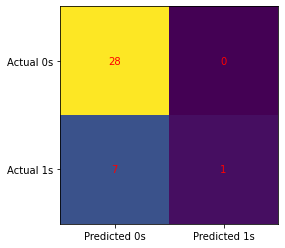

In [765]:
cm = confusion_matrix(y_test.values.ravel(), test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [766]:
# calculate the theta, boundary line
print(LR.intercept_[0])
print(LR.coef_.T[0][0])

-0.26706985579023645
0.09523016081618628


#### Finally, let's see what happens if we try to fit multiple features vs. Market Move with one day lag

In [767]:
num_cols_1 = ['Average_Sentence_Score', 'Average_Paragraph_Score', 'Article_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Market_Move_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [768]:
LR = LogisticRegression(C=0.01).fit(X_train_xformed,y_train.values.ravel())

In [769]:
# Predict!
print('Train Scores\n')
train_pred = LR.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = LR.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Jaccard score: {jaccard_score(y_test.values.ravel(), test_pred,pos_label=0)}') # bad jaccard score
print(f'Log loss score: {log_loss(y_test.values.ravel(), test_pred)}')

Train Scores

Precision Score: 0.70
Recall Score: 1.00
F1 Score: 0.82

Test Scores

Precision Score: 0.47
Recall Score: 1.00
F1 Score: 0.64
Jaccard score: 0.4722222222222222
Log loss score: 18.228798652869525


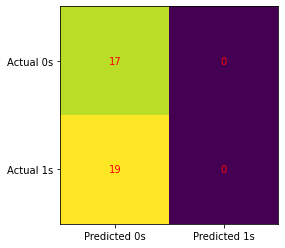

In [770]:
cm = confusion_matrix(y_test.values.ravel(), test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [771]:
# calculate the theta, boundary line
print(LR.intercept_[0])
print(LR.coef_.T)

-0.8430777880177348
[[0.02566412]
 [0.02881359]
 [0.04421665]]


#### try other combinations as well (by intuition, these will not have a strong relationship either)

In [772]:
num_cols_1 = ['Min_Sentence_Score']
num_cols_2 = ['Average_Paragraph_Score','Min_Sentence_Score', 'Max_Sentence_Score','Min_Paragraph_Score']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1)
    ])

y_col = ['Market_Move_Lag']

# split train and testing
# 0.3 of the overall dataset will be used for testing (88*0.3)
X_train, X_test, y_train, y_test = train_test_split(merged[num_cols_1], merged[y_col], test_size=0.3)

# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

In [773]:
LR = LogisticRegression(C=0.01).fit(X_train_xformed,y_train.values.ravel())

In [774]:
# Predict!
print('Train Scores\n')
train_pred = LR.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = LR.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Jaccard score: {jaccard_score(y_test.values.ravel(), test_pred,pos_label=0)}') # bad jaccard score
print(f'Log loss score: {log_loss(y_test.values.ravel(), test_pred)}')

Train Scores

Precision Score: 0.59
Recall Score: 1.00
F1 Score: 0.74

Test Scores

Precision Score: 0.72
Recall Score: 1.00
F1 Score: 0.84
Jaccard score: 0.7222222222222222
Log loss score: 9.594104554141856


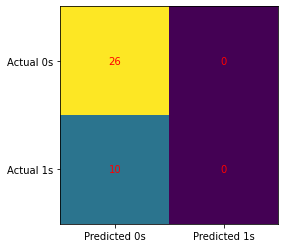

In [775]:
cm = confusion_matrix(y_test.values.ravel(), test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

#### Conclusion on logistic regression
1. By directly visualizing how the points are scattered
- As we could see from the scatter plot for each combination made above, the points are scattered around without any specific patterns, and we have less ones than zeros (meaning market move is mostly downward)
2. By looking at the score reports
- Recall scores are always high, with low precision scores, we could refer to the confusion matrix to make sense of this phenomenon.
3. By looking at the confusion matrix
- As seen from the confusion matrix, nearly for each logistic regression model we made, it always predicted "0" when it is actual "1". This gives us a really low precision scores. If we look at the model, we could see that **it tries to predict "0" for most of the time**, this is why we always have a **high recall but a low precision score**.

There's a non-linear relationship between the features and the outcome, so both linear regression and logistic regression might not be a good fit.

In [776]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svc = svm.SVC(kernel='rbf',degree=3) # Linear Kernel

#Train the model using the training sets
svc.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
test_pred = svc.predict(X_test)

In [777]:
# Model Accuracy: how often is the classifier correct?
print('Test Scores\n')

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print("Accuracy:",metrics.accuracy_score(y_test.values.ravel(), test_pred))

Test Scores

Precision Score: 0.72
Recall Score: 1.00
F1 Score: 0.84
Accuracy: 0.7222222222222222


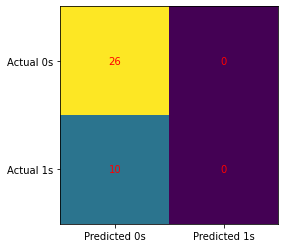

In [778]:
cm = confusion_matrix(y_test.values.ravel(), test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn import metrics

#### 1. Market Move no lag Decision Tree (feature: Average sentence score)

In [26]:
num_cols_1 = ['Average_Sentence_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [27]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)
scoreTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
scoreTree.fit(X_train_xformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [28]:
predTree = scoreTree.predict(X_test_xformed)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.6388888888888888


In [29]:
# Predict!

print('Train Scores\n')
train_pred = scoreTree.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = scoreTree.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.75
Recall Score: 0.66
F1 Score: 0.65

Test Scores

Precision Score: 0.69
Recall Score: 0.64
F1 Score: 0.61


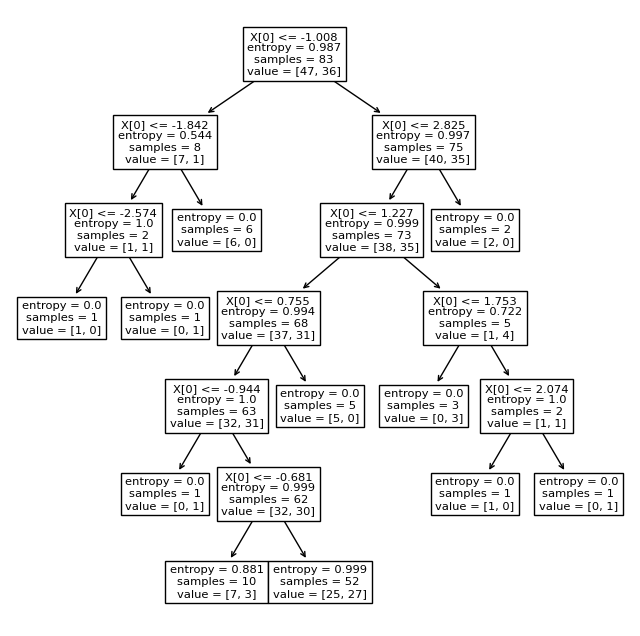

In [30]:
plt.figure(figsize=(8, 8))
tree.plot_tree(scoreTree)
plt.show()

#### 2. Market Move one day lag Decision Tree (feature: Average sentence score)

In [17]:
num_cols_1 = ['Average_Sentence_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move_Lag']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [18]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)
scoreTree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
scoreTree.fit(X_train_xformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [19]:
predTree = scoreTree.predict(X_test_xformed)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.6388888888888888


In [20]:
# Predict!

print('Train Scores\n')
train_pred = scoreTree.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = scoreTree.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.81
Recall Score: 0.72
F1 Score: 0.67

Test Scores

Precision Score: 0.47
Recall Score: 0.64
F1 Score: 0.54


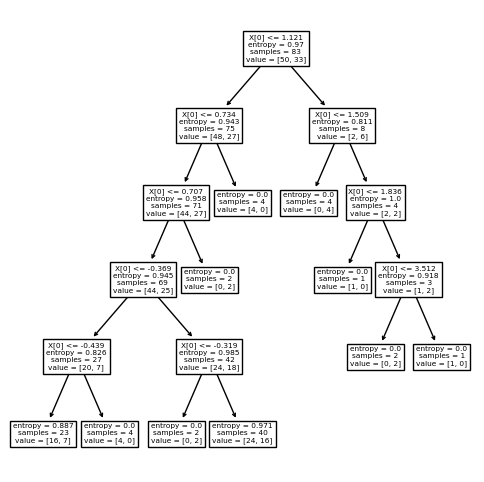

In [21]:
plt.figure(figsize=(6, 6))
tree.plot_tree(scoreTree)
plt.show()

#### 3. Market Move no lag Decision Tree (feature: Average paragraph score)

In [790]:
num_cols_1 = ['Average_Paragraph_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [791]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)
scoreTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
scoreTree.fit(X_train_xformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [792]:
predTree = scoreTree.predict(X_test_xformed)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.5555555555555556


In [793]:
# Predict!

print('Train Scores\n')
train_pred = scoreTree.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = scoreTree.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.76
Recall Score: 0.72
F1 Score: 0.71

Test Scores

Precision Score: 0.51
Recall Score: 0.56
F1 Score: 0.49


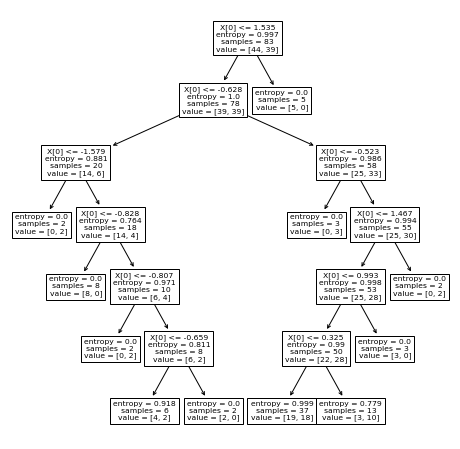

In [794]:
plt.figure(figsize=(8, 8))
tree.plot_tree(scoreTree)
plt.show()

#### 4. Market Move one day lag Decision Tree (feature: Average paragraph score)

In [32]:
num_cols_1 = ['Average_Paragraph_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move_Lag']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [33]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)
scoreTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
scoreTree.fit(X_train_xformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [34]:
predTree = scoreTree.predict(X_test_xformed)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.6111111111111112


In [35]:
# Predict!

print('Train Scores\n')
train_pred = scoreTree.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = scoreTree.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.82
Recall Score: 0.75
F1 Score: 0.70

Test Scores

Precision Score: 0.61
Recall Score: 1.00
F1 Score: 0.76


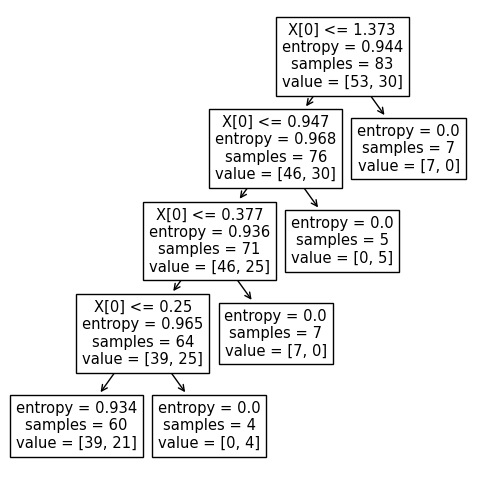

In [36]:
plt.figure(figsize=(6, 6))
tree.plot_tree(scoreTree)
plt.show()

#### 5. Market Move no lag Decision Tree (feature: Article score)

In [37]:
num_cols_1 = ['Article_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [38]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)
scoreTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
scoreTree.fit(X_train_xformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [39]:
predTree = scoreTree.predict(X_test_xformed)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.5


In [40]:
# Predict!

print('Train Scores\n')
train_pred = scoreTree.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

print('\nTest Scores\n')
test_pred = scoreTree.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.91
Recall Score: 0.89
F1 Score: 0.90

Test Scores

Precision Score: 0.50
Recall Score: 0.50
F1 Score: 0.50


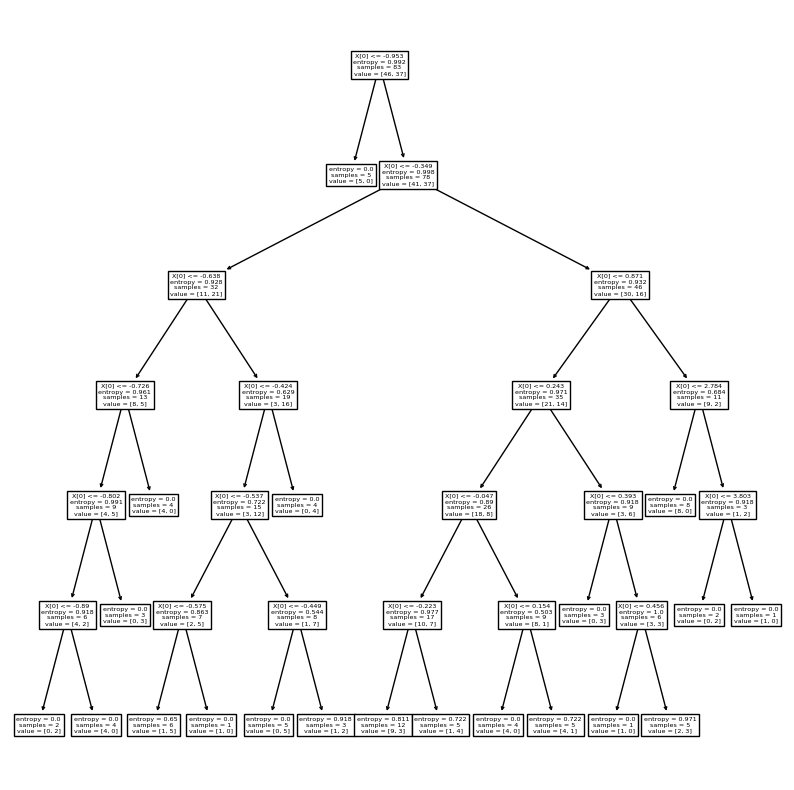

In [41]:
plt.figure(figsize=(10, 10))
tree.plot_tree(scoreTree)
plt.show()

#### 6. Market Move one day lag Decision Tree (feature: Article score)

In [46]:
num_cols_1 = ['Article_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move_Lag']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [49]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)
scoreTree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
scoreTree.fit(X_train_xformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [50]:
predTree = scoreTree.predict(X_test_xformed)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.5833333333333334


In [51]:
# Predict!

print('Train Scores\n')
train_pred = scoreTree.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(train_pred)):.2f}')

print('\nTest Scores\n')
test_pred = scoreTree.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.79
Recall Score: 0.69
F1 Score: 0.60

Test Scores

Precision Score: 0.39
Recall Score: 0.58
F1 Score: 0.47


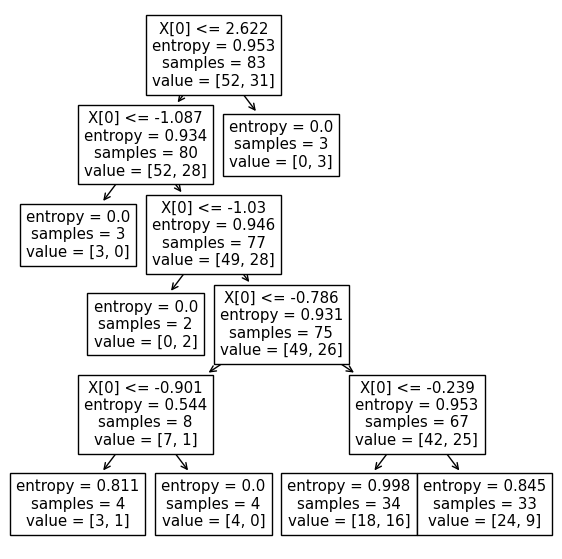

In [52]:
plt.figure(figsize=(7, 7))
tree.plot_tree(scoreTree)
plt.show()

#### 6. Market Move one day lag Decision Tree (feature: Article score, Average_Sentence_Score, Average_Paragraph_Score)

In [56]:
num_cols_1 = ['Average_Paragraph_Score', 'Average_Sentence_Score', 'Article_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move_Lag']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [57]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)
scoreTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
scoreTree.fit(X_train_xformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [58]:
predTree = scoreTree.predict(X_test_xformed)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.6111111111111112


In [59]:
# Predict!

print('Train Scores\n')
train_pred = scoreTree.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

print('\nTest Scores\n')
test_pred = scoreTree.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.80
Recall Score: 0.70
F1 Score: 0.63

Test Scores

Precision Score: 0.56
Recall Score: 0.61
F1 Score: 0.57


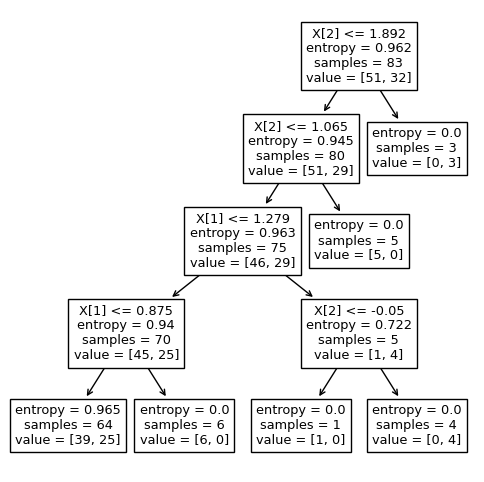

In [60]:
plt.figure(figsize=(6, 6))
tree.plot_tree(scoreTree)
plt.show()

#### Conclusion on Decision Tree:

## Random Forest

#### Model trained with Average Paragraph Score And Market Move with one day lag

In [61]:
num_cols_1 = ['Average_Paragraph_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move_Lag']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [62]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

forest_clf = RandomForestClassifier(**{'n_estimators':55, 'max_depth':8})

forest_clf = forest_clf.fit(X_train_xformed, y_train.values.ravel())

In [63]:
# Predict!

print('Train Scores\n')
train_pred = forest_clf.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

print('\nTest Scores\n')
test_pred = forest_clf.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.99
Recall Score: 0.99
F1 Score: 0.99

Test Scores

Precision Score: 0.59
Recall Score: 0.58
F1 Score: 0.59


#### Market Move one day lag Decision Tree (feature: Article score, Average_Sentence_Score, Average_Paragraph_Score)

In [64]:
num_cols_1 = ['Average_Paragraph_Score', 'Average_Sentence_Score', 'Article_Score'] 

cat_cols = []

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_1), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols_1 + cat_cols

y_col_log = ['Market_Move_Lag']

# y with no lag
X_train, X_test, y_train, y_test = train_test_split(merged[all_x_cols], merged[y_col_log], test_size=0.3)

In [67]:
# Train!

X_train_xformed = pipeline.fit_transform(X_train)
X_test_xformed = pipeline.transform(X_test)

forest_clf = RandomForestClassifier(**{'n_estimators':55, 'max_depth':8})

forest_clf = forest_clf.fit(X_train_xformed, y_train.values.ravel())

In [68]:
# Predict!

print('Train Scores\n')
train_pred = forest_clf.predict(X_train_xformed)

print(f'Precision Score: {precision_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_train.values.ravel(), train_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

print('\nTest Scores\n')
test_pred = forest_clf.predict(X_test_xformed)

print(f'Precision Score: {precision_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'Recall Score: {recall_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')
print(f'F1 Score: {f1_score(y_test.values.ravel(), test_pred, average="weighted", labels=np.unique(test_pred)):.2f}')

Train Scores

Precision Score: 0.94
Recall Score: 0.94
F1 Score: 0.94

Test Scores

Precision Score: 0.62
Recall Score: 0.61
F1 Score: 0.58


In [69]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

In [70]:
# bootstrap predictions
accuracy = []
n_iterations = 5000
for i in range(n_iterations):
    X_bs, y_bs = resample(X_train_xformed, y_train.values, replace=True)
    # make predictions
    y_hat = forest_clf.predict(X_bs)
    # evaluate model
    score = accuracy_score(y_bs, y_hat)
    accuracy.append(score)

In [838]:
np.mean(accuracy)

0.9882192771084337

In [839]:
accuracy_series = pd.Series(accuracy)

In [840]:
print(f'mean: {accuracy_series.mean():.2f}')
print(f'variance: {accuracy_series.var():.2f}')
print(f'standard deviation: {accuracy_series.std():.2f}')
print(f'standard error: {accuracy_series.sem():.2f}')
print(f'5%: {accuracy_series.quantile(.05):.2f}')
print(f'95%: {accuracy_series.quantile(.95):.2f}')

mean: 0.99
variance: 0.00
standard deviation: 0.01
standard error: 0.00
5%: 0.96
95%: 1.00


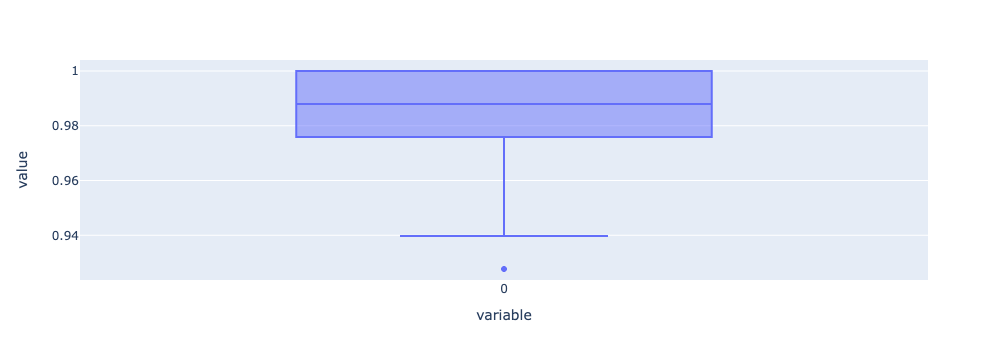

In [841]:
import plotly.express as px  # import the plotly express to visualize
fig = px.box(accuracy_series)
fig.show()

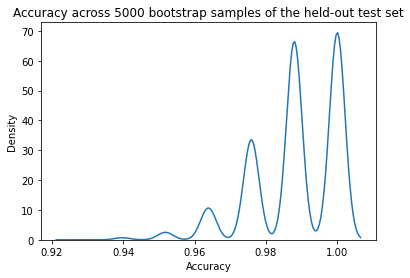

In [842]:
import seaborn as sns
# plot distribution of accuracy
sns.kdeplot(accuracy)
plt.title("Accuracy across 5000 bootstrap samples of the held-out test set")
plt.xlabel("Accuracy")
plt.show()

#### Overall Conclusion:

There's relatively weak linear relationship between nearly all the features with the sentimental scores (both in simple linear regression and in multiple linear regression). In this case, both linear regression and logistic regression might not be good fit, also shown in the evaluation scores above. Therefore, the tree structure is ideal for capturing interactions between features in the data.